In [31]:
#Shubham Singh
#21250025

#Task-4_ Assignment-5
# Trajectory generator class for robots (Common for all robots)

import numpy as np
import sympy as sp
import math
import matplotlib.pyplot as plt
from matplotlib import rc


class TrajectoryGenerator():                                                #for generating P2P joint space trajectories

    def __init__(self, dq_max, ddq_max, dx_max, ddx_max, control_freq=0):
        self._tg = TrapezoidalGenerator(dq_max=dq_max, ddq_max=ddq_max)
        self._dq_max = dq_max
        self._ddq_max = ddq_max
        self._dx_max = dx_max
        self._ddx_max = ddx_max
        self._control_freq = control_freq

    def generate_p2p_trajectory(self, qs_0, qs_f, n=100, plot=False):
        self._tg.set_frequency(self._control_freq)
        self._tg.set_limits(self._dq_max, self._ddq_max)
        qs, dqs, ddqs, ts = self._generate_equalized_profiles(qs_0, qs_f, n)
        if plot:
            TrajectoriesPlotter.plot_joint(ts, qs, dqs, ddqs)
        return np.array(qs)                                                # returns joint position array

    def _generate_equalized_profiles(self, qs_0, qs_f, n):                 #for generating equalized profile for n joints
        ts_1, taus = [], []
        for q_0, q_f in zip(qs_0, qs_f):
            t_1, tau = self._tg.generate_coefficients(q_0, q_f)
            ts_1.append(t_1)
            taus.append(tau) 
        t_1_max = max(ts_1)
        tau_max = max(taus)
        ts = self._tg.get_t(t_1_max, tau_max, n)
        qs, dqs, ddqs = [], [], []
        for q_0, q_f in zip(qs_0, qs_f):
            delta_q = q_f - q_0
            dq_cur = delta_q / tau_max
            ddq_cur = delta_q / (tau_max * t_1_max)
            self._tg.set_current_limits(dq_cur, ddq_cur)
            self._tg.set_positions(q_0, q_f)
            qs.append(self._tg.get_q(t_1_max, tau_max, n))
            dqs.append(self._tg.get_dq(t_1_max, tau_max, n))
            ddqs.append(self._tg.get_ddq(t_1_max, tau_max, n))
        return qs, dqs, ddqs, ts

    def get_dq_from_dx(self, qs, dxs, J_inv, ts=None):
        dqs = []
        for dx, q in zip(dxs, qs.T):
            qs_dict = {}
            for i in range(len(q)):
                qs_dict[sp.symbols(f"q_{i}")] = q[i]
            dqs.append(np.array(J_inv.evalf(subs=qs_dict) * sp.Matrix(dx),
                                np.float))
        dqs = np.array(dqs)[:, :, 0].T
        if ts is not None:
            TrajectoriesPlotter.plot_joint_no_acc(ts, qs, dqs)
        return dqs

    def interpolate(self, p_start, p_finish, n):
        v = np.array([p_finish]) - np.array([p_start])
        t = np.array([np.linspace(0, 1, n)]).T
        return p_start + t.dot(v)

class TrajectoriesPlotter():
    def plot_joint(ts, qs, dqs, ddqs):
        rc('text', usetex=False)
        fig, axs = plt.subplots(len(qs), 3, sharex=True, figsize=(8, 5))
        fig.suptitle("Trajectories of Joint-1, Joint-2 & Joint-3", color = 'r', weight = 'bold')
        labels = ["", r"\dot", r"\ddot"]
        for i, (q, dq, ddq) in enumerate(zip(qs, dqs, ddqs)):
            plots = [q, dq, ddq]
            for j, (plot, label) in enumerate(zip(plots, labels)):
                if len(qs) != 1:
                    axs[i, j].plot(ts, plot)
                    axs[i, j].set_title(f"${label}q_{i}$", weight = 'bold')
                    axs[i, j].set_xlabel(f't (seconds)', weight = 'bold')
                    axs[i, j].set_ylabel(f'q (radians)', weight = 'bold')
                else:
                    axs[j].plot(ts, plot)
                    axs[j].set_title(f"${label}q_{i}$", weight = 'bold')
                    axs[j].set_xlabel(f't (seconds)', weight = 'bold')
                    axs[j].set_ylabel(f'q (radians)', weight = 'bold')
        plt.tight_layout()
        plt.show()

class TrapezoidalGenerator():                                        #for generating trapezoidal velocity profiles of joints

    def __init__(self, dq_max, ddq_max, control_freq=0):             #defining velocity and acceleration limits
        self._dq_max = dq_max
        self._ddq_max = ddq_max
        self._control_freq = control_freq

    def set_limits(self, dq_max, ddq_max):
        self._dq_max = dq_max
        self._ddq_max = ddq_max

    def set_frequency(self, control_freq):
        self._control_freq = control_freq

    def generate_coefficients(self, q_init, q_final):      #q_init is the initial position
                                                            #q_final is the final position
        self.set_positions(q_init, q_final)
        delta_q = abs(self._q_final - self._q_init)
        dq_max_prime = np.sqrt(delta_q * self._ddq_max)

        if dq_max_prime < self._dq_max:
            t_1 = dq_max_prime / self._ddq_max
            tau = t_1
            self._dq_max_current = dq_max_prime
        else:
            t_1 = self._dq_max / self._ddq_max                                    #trapezoidal profile
            tau = delta_q / self._dq_max
            self._dq_max_current = self._dq_max

        self._ddq_max_current = self._ddq_max

        if self._control_freq != 0: 
            n = ceil(t_1 * self._control_freq)                                    #controller frequency
            m = ceil(tau * self._control_freq)
            t_1 = n / self._control_freq
            tau = m / self._control_freq
        return t_1, tau

    def set_current_limits(self, dq_max_current, ddq_max_current):                #updates current acceleration and velocity limits
        self._dq_max_current = dq_max_current
        self._ddq_max_current = ddq_max_current

    def set_positions(self, q_init, q_final):                                     #updates current and desired positions
        self._q_init = q_init
        self._q_final = q_final

    @property
    def dq_max_current(self):
        return self._dq_max_current

    def get_t(self, t_1, tau, n):
        t_acc, t_no_acc, t_dec = self._get_times(t_1, tau, n)
        return np.hstack([t_acc, t_no_acc, t_dec])

    def get_q(self, t_1, tau, n):
        t_acc, t_no_acc, _ = self._get_times(t_1, tau, n)
        t_no_acc = t_no_acc - t_acc[-1]
        if len(t_acc) == 0:
            raise ValueError("Not enough points. Please, increase n")
        q_acc = self._q_init + 0.5 * self._ddq_max_current * t_acc**2
        q_no_acc = q_acc[-1] + self._dq_max_current * t_no_acc

                                                                                            # Check if profile is trapezoidal or triangular
        if len(q_no_acc) != 0:
            start_q = q_no_acc[-1]
        else:
            start_q = q_acc[-1]

        q_dec = start_q + self._dq_max_current * \
            t_acc - 0.5 * self._ddq_max_current * t_acc**2

        return np.hstack([q_acc, q_no_acc, q_dec])

    def get_dq(self, t_1, tau, n):                                                    #samples points between t_1 and tau
        t_acc, t_no_acc, t_dec = self._get_times(t_1, tau, n)
        if len(t_acc) == 0:
            raise ValueError("Not enough points. Please, increase n")
        q_acc = self._ddq_max_current * t_acc
        q_no_acc = np.ones(len(t_no_acc)) * self._dq_max_current
        q_dec = q_acc[-1] - q_acc

        return np.hstack([q_acc, q_no_acc, q_dec])

    def get_ddq(self, t_1, tau, n):                       #samples n points from accn profile
        t_acc, t_no_acc, t_dec = self._get_times(t_1, tau, n)
        q_acc = self._ddq_max_current * np.ones(len(t_acc))
        q_no_acc = np.zeros(len(t_no_acc))
        q_dec = -self._ddq_max_current * np.ones(len(t_dec))
        return np.hstack([q_acc, q_no_acc, q_dec])

    def _get_times(self, t_1, tau, n):
        step = n / (tau + t_1)
        t_acc = np.linspace(0, t_1, int(step * t_1))
        t_no_acc = np.linspace(t_1, tau, int(step * (tau - t_1)))
        t_dec = np.linspace(tau, tau + t_1, int(step * t_1))
        return t_acc, t_no_acc, t_dec



In [32]:
# Shubham Singh
# 21250025
# Puma Robot Inverse Kinematics Class

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pickle
from abc import ABC, abstractmethod

class SymbolicTransformation():
    def __init__(self, sequence_string, variables=None, f_of_t=None, simplify=False):
        self._seq = sequence_string
        self._tokens = SymbolicTransformation._tokens_from_sequence(self._seq)
        self._tfs = [sp.eye(4)] * (len(self._tokens) + 1)
        self._token_to_transform = {
            'Tx': self.get_Tx,
            'Ty': self.get_Ty,
            'Tz': self.get_Tz,
            'Rx': self.get_Rx,
            'Ry': self.get_Ry,
            'Rz': self.get_Rz,
            'Txi': self.get_Tx_inv,
            'Tyi': self.get_Ty_inv,
            'Tzi': self.get_Tz_inv,
            'Rxi': self.get_Rx_inv,
            'Ryi': self.get_Ry_inv,
            'Rzi': self.get_Rz_inv,
            'Txd': self.get_Txd,
            'Tyd': self.get_Tyd,
            'Tzd': self.get_Tzd,
            'Rxd': self.get_Rxd,
            'Ryd': self.get_Ryd,
            'Rzd': self.get_Rzd,
        }

        if variables is None:
            self._variables = []
            t_index = 0
            r_index = 0

            for token in self._tokens:
                if token in self._token_to_transform.keys():
                    if token.startswith('T'):
                        self._variables.append(f"d_{t_index}")
                        t_index += 1
                    elif token.startswith('R'):
                        self._variables.append(f"q_{r_index}")
                        r_index += 1
                else:
                    raise ValueError("Transformation error")
        else:
            if len(variables) != len(self._tokens):
                raise ValueError("Transformation and variable size error")

            self._variables = variables

        self._f_of_t = {}
        if f_of_t is None:
            for var in self._variables:
                self._f_of_t[var] = False
        else:
            for var, val in zip(self._variables, f_of_t):
                self._f_of_t[var] = val

        self._generate_transformation(simplify=simplify)

    def _generate_transformation(self, simplify=False):
        for i, (token, var) in enumerate(zip(self._tokens, self._variables)):
            self._tfs[i + 1] = self._tfs[i] * self._from_token(token, var)
            if simplify:
                self._tfs[i + 1] = sp.simplify(self._tfs[i + 1])
    def _from_token(self, token, variable_name):
        try:
            f_of_t = False
            if variable_name in self._f_of_t:
                f_of_t = self._f_of_t[variable_name]
            return self._token_to_transform[token](variable_name, f_of_t)
        except Exception:
            raise ValueError("Unknown token")
    def valid_token(self, token):
        if token in self._token_to_transform:
            return True
        return False
    @staticmethod
    def _tokens_from_sequence(sequence):
        return [s for s in re.split("([A-Z][^A-Z]*)", sequence) if s]
    def __getitem__(self, i):
        return self._tfs[-1][i]
    def __mul__(self, other):
        new_sequence = self._seq + other._seq
        new_vars = self._variables + other._variables
        return SymbolicTransformation(new_sequence, new_vars)
    def __rmul__(self, other):
        new_sequence = other._seq + self._seq
        new_vars = other._variables + self._variables
        return SymbolicTransformation(new_sequence, new_vars)
    @property
    def transformation(self):
        return self._tfs[-1]
    @property
    def frames(self):
        return self._tfs[1:]
    @property
    def variables(self):
        return self._variables

    def substitute(self, var_value_pairs):
        var_value_tuples = []
        for name, value in var_value_pairs:
            var_value_tuples.append((sp.symbols(name), value))
        for i in range(len(self._tfs)):
            self._tfs[i] = self._tfs[i].subs(var_value_tuples)

    def evaluate(self, values):
        values_dict = {}
        for value, name in zip(values, self._variables):
            values_dict[sp.symbols(name)] = value

        return self.transformation.evalf(subs=values_dict)

    def evaluate_tuples(self, name_value_tuples):
        values_dict = {}
        for name, value in name_value_tuples:
            values_dict[sp.symbols(name)] = value
        return self.transformation.evalf(subs=values_dict)

    def inv(self):
        new_sequence = ""
        for token in self._tokens[::-1]:
            if token[-1] == 'i':
                new_sequence += token[:-1]
            else:
                new_sequence += (token + "i")
        new_vars = self._variables[::-1]
        return SymbolicTransformation(new_sequence, new_vars)

    def get_rotation(self):
        R = sp.Matrix(sp.eye(4))
        R[:3, :3] = self.transformation[:3, :3]
        return R

    def print(self):
        print()
        sp.pprint(self.transformation)
        print()

    @staticmethod
    def _get_symbol(symbol, f_of_t=False):
        if f_of_t:
            t = sp.Symbol('t')
            s = sp.Function(symbol)(t)
        else:
            s = sp.Symbol(symbol)
        return s

    @staticmethod
    def get_jacobian_column(J):
        return sp.Matrix([
            J[0, 3],
            J[1, 3],
            J[2, 3],
            J[2, 1],
            J[0, 2],
            J[1, 0],
        ])

    @staticmethod
    def get_scew(x, y, z, f_of_t=False):
        x = SymbolicTransformation._get_symbol(x, f_of_t)
        y = SymbolicTransformation._get_symbol(y, f_of_t)
        z = SymbolicTransformation._get_symbol(z, f_of_t)
        return sp.Matrix([
            [0, -z, y],
            [z, 0, -x],
            [-y, x, 0],
        ])

    @staticmethod
    def get_inertia_matrix(index=0):
        Ixx = sp.symbols(f"Ixx_{index}")
        Iyy = sp.symbols(f"Iyy_{index}")
        Izz = sp.symbols(f"Izz_{index}")
        Ixy = sp.symbols(f"Ixy_{index}")
        Iyz = sp.symbols(f"Iyz_{index}")
        Ixz = sp.symbols(f"Ixz_{index}")
        return sp.Matrix([[Ixx, Ixy, Ixz],
                          [Ixy, Iyy, Iyz],
                          [Ixz, Iyz, Izz]])

    @staticmethod
    def get_Tx(symbol='x', f_of_t=False):
        x = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, x],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Tx_inv(symbol='x', f_of_t=False):
        x = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, -x],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Ty(symbol='y', f_of_t=False):
        y = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, y],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Ty_inv(symbol='y', f_of_t=False):
        y = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, -y],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Tz(symbol='z', f_of_t=False):
        z = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, z],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Tz_inv(symbol='z', f_of_t=False):
        z = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, -z],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Rx(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1.0, 0.0, 0.0, 0.0],
            [0.0, sp.cos(q), -sp.sin(q), 0.0],
            [0.0, sp.sin(q), sp.cos(q), 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ])

    @staticmethod
    def get_Ry(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [sp.cos(q), 0.0, sp.sin(q), 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [-sp.sin(q), 0.0, sp.cos(q), 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ])

    @staticmethod
    def get_Rz(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [sp.cos(q), -sp.sin(q), 0.0, 0.0],
            [sp.sin(q), sp.cos(q), 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ])

    @staticmethod
    def get_Rx_inv(symbol='q', f_of_t=False):
        return SymbolicTransformation.get_Rx(symbol).T

    @staticmethod
    def get_Ry_inv(symbol='q', f_of_t=False):
        return SymbolicTransformation.get_Ry(symbol).T

    @staticmethod
    def get_Rz_inv(symbol='q', f_of_t=False):
        return SymbolicTransformation.get_Rz(symbol).T

    @staticmethod
    def get_Txd(symbol='q', f_of_t=False):
        return sp.Matrix([
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

    @staticmethod
    def get_Tyd(symbol='q', f_of_t=False):
        return sp.Matrix([
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

    @staticmethod
    def get_Tzd(symbol='q', f_of_t=False):
        return sp.Matrix([
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
        ])

    @staticmethod
    def get_Rxd(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [0.0, 0.0, 0.0, 0.0],
            [0.0, -sp.sin(q), -sp.cos(q), 0.0],
            [0.0, sp.cos(q), -sp.sin(q), 0.0],
            [0.0, 0.0, 0.0, 0.0],
        ])

    @staticmethod
    def get_Ryd(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [-sp.sin(q), 0.0, sp.cos(q), 0.0],
            [0.0, 0.0, 0.0, 0.0],
            [-sp.cos(q), 0.0, -sp.sin(q), 0.0],
            [0.0, 0.0, 0.0, 0.0],
        ])

    @staticmethod
    def get_Rzd(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [-sp.sin(q), -sp.cos(q), 0.0, 0.0],
            [sp.cos(q), -sp.sin(q), 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0]
        ])

class Robot(ABC):
    epsilon = 1e-5
    @abstractmethod
    def forward_kinematics(self, q_values):   
        pass
    @abstractmethod
    def inverse_kinematics(self, T):
         pass
    def set_transforms(self, T_base=None, T_tool=None):
        if T_base is None:
            self.T_base = sp.eye(4)
        else:
            self.T_base = sp.Matrix(T_base)
        if T_tool is None:
            self.T_tool = sp.eye(4)
        else:
            self.T_tool = sp.Matrix(T_tool)

    def set_lengths(self, lengths):
        if lengths is None:
            self._ls = (0.8, 0.8)
        else:
            self._ls = lengths
        return Robot
        
class Puma(Robot):
    ls = (1.0, 1.0, 1.0)
    qs_lim_deg = ((-360.0, 360.0),
                  (-360.0, 360.0),
                  (-360.0, 360.0))

    def __init__(self, T_base=None, T_tool=None):
    
        self.set_transforms(T_base, T_tool)

        self._generate_value_pairs()
        self._calculate_limits_radians() 
        self._precalculate_data()

    def _generate_value_pairs(self):
        value_pairs = []
        for i in range(len(self.ls)):
            value_pairs.append((f"l_{i}", self.ls[i]))
        self._value_pairs = value_pairs

    def _calculate_limits_radians(self):   
        self.qs_lim_rad = tuple(
            (np.deg2rad(x[0]), np.deg2rad(x[1])) for x in self.qs_lim_deg)

    def _precalculate_data(self): 
            self._Ts = SymbolicTransformation("RzTzRyTxRyTx",
                          ['q_0', 'l_0', 'q_1', 'l_1', 'q_2', 'l_2'])
            self._Ts.substitute(self._value_pairs)

    def forward_kinematics(self, q_values, plot=True):                 #calculates forward kinematics        
        qs_dict = {}
        for i in range(len(q_values)):
            qs_dict[sp.symbols(f"q_{i}")] = q_values[i]
        self._numeric_frames = []
        for frame in self._Ts.frames:
            self._numeric_frames.append(frame.evalf(subs=qs_dict))
        T = self.T_base * self._numeric_frames[-1] * self.T_tool

        if plot:
            self._show_fk()

        return np.array(T, dtype=np.float)
    def _show_fk(self):
    
        frames = [self.T_base]

        for frame, var in zip(self._numeric_frames, self._Ts.variables):
            if var[0] == 'q':
                frames.append(self.T_base * frame)

        frames.append(self.T_base * self._numeric_frames[-1])
        frames.append(frames[-1] * self.T_tool)

        self._tp.plot_numeric_frames(frames, axis_len=self.ls[0] / 4)

    def inverse_kinematics(self, T, m=1, k=1):
        
        if abs(m) != 1:
            print("error")
            m = 1

        if abs(k) != 1:
            print("error")
            k = 1

        T = sp.Matrix(T)
        T_0 = self.T_base.inv() * T * self.T_tool.inv()

        x, y, z = float(T_0[0, 3]), float(T_0[1, 3]), float(T_0[2, 3])
        x_prime = k * np.sqrt(x**2 + y**2)
        z_prime = self.ls[0] - z

        arccos_numerator = x_prime**2 + \
            z_prime**2 - self.ls[1]**2 - self.ls[2]**2
        arccos_denominator = 2.0 * self.ls[1] * self.ls[2]
        arccos = arccos_numerator / arccos_denominator

      
        if abs(arccos) > 1:                                  #workspace check
            print("Not in workspace")
            return np.array([0.0, 0.0, 0.0])

        q_2 = m * np.arccos(arccos)

        beta = np.arctan2(self.ls[2] * np.sin(m * q_2),
                          self.ls[1] + self.ls[2] * np.cos(q_2))
        q_1 = np.arctan2(z_prime, x_prime) - m * beta

        A = self.ls[1] * np.cos(q_1) + self.ls[2] * np.cos(q_1 + q_2)

        if abs(A) < self.epsilon:
            print("Arm up, q_0 = 0")
            q_0 = 0.0
        else:
            q_0 = np.arctan2(y, x)

        qs = np.array([q_0, q_1, q_2])

        out_of_limits = False
        for i in range(len(qs)):
            if qs[i] < self.qs_lim_rad[i][0] or qs[i] > self.qs_lim_rad[i][1]:
                print(f"[INFO] q_{i} = {np.rad2deg(qs[i]):.3f} "
                      f"error")
                out_of_limits = True
        if out_of_limits:
            return np.array([0.0, 0.0, 0.0])
        return qs

    def move_joints(self, qs):
        plt.ion()
        Ts = []
        for q in qs:
            for T in Ts:
                self._tp.plot_position(T)

            T = self.forward_kinematics(q, plot=True)
            Ts.append(T)

            plt.pause(1e-9)
            self._tp.ax.cla()
        plt.ioff()
        for T in Ts[:-1]:
            self._tp.plot_position(T, show=False)
        self.forward_kinematics(qs[-1], plot=True)

    def move_via_points(self, pts):
       
        plt.ion()
        Ts = []
        qs = []
        for pt in pts:
            for T in Ts:
                self._tp.plot_position(T)

            self._tp.ax.scatter(
                pts[0][0],
                pts[0][1],
                pts[0][2],
                c='red',
                s=40,
                alpha=0.6,
            )

            self._tp.ax.scatter(
                pts[-1][0],
                pts[-1][1],
                pts[-1][2],
                c='red',
                s=40,
                alpha=0.6,
            )

            T_IK = np.array([
                [1, 0, 0, pt[0]],
                [0, 1, 0, pt[1]],
                [0, 0, 1, pt[2]],
                [0, 0, 0, 1]
            ])

            q = self.inverse_kinematics(T_IK)
            qs.append(q)
            T = self.forward_kinematics(q, plot=True)
            Ts.append(T)

            plt.pause(1e-9)
            self._tp.ax.cla()
        plt.ioff()
        for T in Ts[:-1]:
            self._tp.plot_position(T, show=False)
        self.forward_kinematics(q, plot=True)

        return np.array(qs).T
        

In [33]:
#Shubham Singh
#21250025
# Jacobian Calculator  class (Common for all robots)

from pathlib import Path
import sympy as sp
import re
import pickle

class JacobianCalculator():

    def __init__(self, sequence_string, joint_indices, f_of_t=True, variables=None, T_base=None, T_tool=None, simplify=False):
        self._seq = sequence_string
        self._tokens = SymbolicTransformation._tokens_from_sequence(self._seq)
        self._seq_numeric = []
        self._seq_skew = []
        self._vars_skew = []
        self._ind = joint_indices
        self._validator = SymbolicTransformation('')
        self.simplify = simplify

        self.set_transforms(T_base, T_tool)                                                     #Transformation of the frames            
        if len(self._tokens) != len(self._ind):
            raise ValueError("Size of indices does not match")

        elif type(f_of_t) == bool:
            self._f_of_t = [False] * len(self._ind)
            if f_of_t:
                self._f_of_t = self._ind
        else:
            self._f_of_t = f_of_t
        if variables is None:
            self._variables = []
            t_index = 0
            r_index = 0

            for token, index in zip(self._tokens, self._ind):
                if self._validator.valid_token(token):
                    if token.startswith('T'):
                        self._variables.append(f"d_{t_index}")
                        t_index += 1
                    elif token.startswith('R'):
                        self._variables.append(f"q_{r_index}")
                        r_index += 1
                else:
                    raise ValueError("transformation error")
        else:
            if len(variables) != len(self._tokens):
                raise ValueError("Transformation & variables sizes error")

            self._variables = variables
                                                                                    # Generate sequences for jacobian calculations
        for i, (token, index) in enumerate(zip(self._tokens, self._ind)):
            if index:
                self._seq_numeric.append(''.join(
                    self._tokens[:i] + [f"{token}d"] + self._tokens[i + 1:]))
                self._seq_skew.append(''.join(self._tokens[:i]))

        self._seq_skew.append(''.join(self._tokens))
        self._seq_numeric.append(''.join(self._tokens))

        for seq in self._seq_skew:
            n = len(st._tokens_from_sequence(seq))
            self._vars_skew.append(self._variables[:n])

    def set_transforms(self, T_base=None, T_tool=None):     # Updating base and tool transformations
        if T_base is None:
            self.T_base = sp.eye(4)
        else:
            self.T_base = sp.Matrix(T_base)
        if T_tool is None:
            self.T_tool = sp.eye(4)
        else:
            self.T_tool = sp.Matrix(T_tool)

    def calculate_numeric(self, T_base=None, T_tool=None):         #Calculates Jacobian matrix
        if T_base is None:
            T_base = self.T_base
        if T_tool is None:
            T_tool = self.T_tool
        T_robot = SymbolicTransformation(self._seq_numeric[-1],
                     self._variables,
                     f_of_t=self._f_of_t).transformation
        R = T_base * T_robot * T_tool
        R[0, 3] = R[1, 3] = R[2, 3] = 0.0
        Rt = R.T

        Jrs = []
        for seq in self._seq_numeric[:-1]:
            T_diff = SymbolicTransformation(seq,
                        self._variables,
                        f_of_t=self._f_of_t).transformation
            Jr = T_base * T_diff * T_tool * Rt
            Jrs.append(SymbolicTransformation.get_jacobian_column(Jr).T)

        if self.simplify:
            res = sp.simplify(sp.Matrix(Jrs).T)
        else:
            res = sp.Matrix(Jrs).T                           #calculated jacobian matrix
        return res

def get_symbolic_jacobian_inverse():
        T_base = sp.eye(4)
        T_tool = sp.eye(4)
        variables = ['q_0', 'l_0', 'q_1', 'l_1', 'q_2', 'l_2']
        indices = [1, 0, 1, 0, 1, 0]
        sequence = "RzTzRyTxRyTx"
        jc = JacobianCalculator(sequence, indices, variables=variables, T_base=T_base, T_tool=T_tool, simplify=False)
        ls = (1.0, 1.0, 1.0)          #Length of links of the robot                                  
 
        value_pairs = []
        for i in range(len(ls)):
            value_pairs.append((f"l_{i}", ls[i]))

        J_inv = jc.calculate_numeric()[:3, :3].inv()
        J_inv = sp.simplify(J_inv.subs(value_pairs))

        with open('wb') as output:
            pickle.dump(J_inv, output, pickle.HIGHEST_PROTOCOL)

        return J_inv

def main():
    T_base = sp.eye(4)
    T_tool = sp.eye(4)
    variables = ['q_0', 'l_0', 'q_1', 'l_1', 'q_2', 'l_2']
    indices = [1, 0, 1, 0, 1, 0]
    sequence = "RzTzRyTxRyTx"
    jc = JacobianCalculator(sequence, indices, variables=variables, T_base=T_base, T_tool=T_tool, simplify=False)
    J_num = sp.simplify(jc.calculate_numeric())
    sp.pprint(J_num)
    J_transl = J_num[:3, :3]
    sp.pprint(sp.simplify(J_transl.inv()))
    
class SymbolicTransformation():
    def __init__(self, sequence_string, variables=None, f_of_t=None, simplify=False):
        self._seq = sequence_string
        self._tokens = SymbolicTransformation._tokens_from_sequence(self._seq)
        self._tfs = [sp.eye(4)] * (len(self._tokens) + 1)
        self._token_to_transform = {
            'Tx': self.get_Tx,
            'Ty': self.get_Ty,
            'Tz': self.get_Tz,
            'Rx': self.get_Rx,
            'Ry': self.get_Ry,
            'Rz': self.get_Rz,
            'Txi': self.get_Tx_inv,
            'Tyi': self.get_Ty_inv,
            'Tzi': self.get_Tz_inv,
            'Rxi': self.get_Rx_inv,
            'Ryi': self.get_Ry_inv,
            'Rzi': self.get_Rz_inv,
            'Txd': self.get_Txd,
            'Tyd': self.get_Tyd,
            'Tzd': self.get_Tzd,
            'Rxd': self.get_Rxd,
            'Ryd': self.get_Ryd,
            'Rzd': self.get_Rzd,
        }

        if variables is None:
            self._variables = []
            t_index = 0
            r_index = 0

            for token in self._tokens:
                if token in self._token_to_transform.keys():
                    if token.startswith('T'):
                        self._variables.append(f"d_{t_index}")
                        t_index += 1
                    elif token.startswith('R'):
                        self._variables.append(f"q_{r_index}")
                        r_index += 1
                else:
                    raise ValueError("transformation error")
        else:
            if len(variables) != len(self._tokens):
                raise ValueError("Transformation and variable sizes error")

            self._variables = variables

        self._f_of_t = {}
        if f_of_t is None:
            for var in self._variables:
                self._f_of_t[var] = False
        else:
            for var, val in zip(self._variables, f_of_t):
                self._f_of_t[var] = val

        self._generate_transformation(simplify=simplify)

    def _generate_transformation(self, simplify=False):
        for i, (token, var) in enumerate(zip(self._tokens, self._variables)):
            self._tfs[i + 1] = self._tfs[i] * self._from_token(token, var)
            if simplify:
                self._tfs[i + 1] = sp.simplify(self._tfs[i + 1])

    def _from_token(self, token, variable_name):
        try:
            f_of_t = False
            if variable_name in self._f_of_t:
                f_of_t = self._f_of_t[variable_name]
            return self._token_to_transform[token](variable_name, f_of_t)
        except Exception:
            raise ValueError("Unknown token")

    def valid_token(self, token):
        if token in self._token_to_transform:
            return True
        return False

    @staticmethod
    def _tokens_from_sequence(sequence):
        return [s for s in re.split("([A-Z][^A-Z]*)", sequence) if s]

    def __getitem__(self, i):
        return self._tfs[-1][i]

    def __mul__(self, other):
        new_sequence = self._seq + other._seq
        new_vars = self._variables + other._variables
        return SymbolicTransformation(new_sequence, new_vars)

    def __rmul__(self, other):
        new_sequence = other._seq + self._seq
        new_vars = other._variables + self._variables
        return SymbolicTransformation(new_sequence, new_vars)

    @property
    def transformation(self):
        return self._tfs[-1]

    @property
    def frames(self):
        return self._tfs[1:]

    @property
    def variables(self):
        return self._variables

    def substitute(self, var_value_pairs):
        var_value_tuples = []
        for name, value in var_value_pairs:
            var_value_tuples.append((sp.symbols(name), value))
        for i in range(len(self._tfs)):
            self._tfs[i] = self._tfs[i].subs(var_value_tuples)

    def evaluate(self, values):
        values_dict = {}
        for value, name in zip(values, self._variables):
            values_dict[sp.symbols(name)] = value
        return self.transformation.evalf(subs=values_dict)

    def evaluate_tuples(self, name_value_tuples):
        values_dict = {}
        for name, value in name_value_tuples:
            values_dict[sp.symbols(name)] = value
        return self.transformation.evalf(subs=values_dict)

    def inv(self):
        new_sequence = ""
        for token in self._tokens[::-1]:
            if token[-1] == 'i':
                new_sequence += token[:-1]
            else:
                new_sequence += (token + "i")
        new_vars = self._variables[::-1]
        return SymbolicTransformation(new_sequence, new_vars)

    def get_rotation(self):
        R = sp.Matrix(sp.eye(4))
        R[:3, :3] = self.transformation[:3, :3]
        return R

    def print(self):
        print()
        sp.pprint(self.transformation)
        print()

    @staticmethod
    def _get_symbol(symbol, f_of_t=False):
        if f_of_t:
            t = sp.Symbol('t')
            s = sp.Function(symbol)(t)
        else:
            s = sp.Symbol(symbol)
        return s

    @staticmethod
    def get_jacobian_column(J):
        return sp.Matrix([
            J[0, 3],
            J[1, 3],
            J[2, 3],
            J[2, 1],
            J[0, 2],
            J[1, 0],
        ])

    @staticmethod
    def get_scew(x, y, z, f_of_t=False):
        x = SymbolicTransformation._get_symbol(x, f_of_t)
        y = SymbolicTransformation._get_symbol(y, f_of_t)
        z = SymbolicTransformation._get_symbol(z, f_of_t)
        return sp.Matrix([
            [0, -z, y],
            [z, 0, -x],
            [-y, x, 0],
        ])

    @staticmethod
    def get_inertia_matrix(index=0):
        Ixx = sp.symbols(f"Ixx_{index}")
        Iyy = sp.symbols(f"Iyy_{index}")
        Izz = sp.symbols(f"Izz_{index}")
        Ixy = sp.symbols(f"Ixy_{index}")
        Iyz = sp.symbols(f"Iyz_{index}")
        Ixz = sp.symbols(f"Ixz_{index}")
        return sp.Matrix([[Ixx, Ixy, Ixz],
                          [Ixy, Iyy, Iyz],
                          [Ixz, Iyz, Izz]])

    @staticmethod
    def get_Tx(symbol='x', f_of_t=False):
        x = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, x],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Tx_inv(symbol='x', f_of_t=False):
        x = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, -x],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Ty(symbol='y', f_of_t=False):
        y = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, y],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Ty_inv(symbol='y', f_of_t=False):
        y = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, -y],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Tz(symbol='z', f_of_t=False):
        z = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, z],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Tz_inv(symbol='z', f_of_t=False):
        z = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, -z],
            [0, 0, 0, 1],
        ])

    @staticmethod
    def get_Rx(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [1.0, 0.0, 0.0, 0.0],
            [0.0, sp.cos(q), -sp.sin(q), 0.0],
            [0.0, sp.sin(q), sp.cos(q), 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ])

    @staticmethod
    def get_Ry(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [sp.cos(q), 0.0, sp.sin(q), 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [-sp.sin(q), 0.0, sp.cos(q), 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ])

    @staticmethod
    def get_Rz(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [sp.cos(q), -sp.sin(q), 0.0, 0.0],
            [sp.sin(q), sp.cos(q), 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ])

    @staticmethod
    def get_Rx_inv(symbol='q', f_of_t=False):
        return SymbolicTransformation.get_Rx(symbol).T

    @staticmethod
    def get_Ry_inv(symbol='q', f_of_t=False):
        return SymbolicTransformation.get_Ry(symbol).T

    @staticmethod
    def get_Rz_inv(symbol='q', f_of_t=False):
        return SymbolicTransformation.get_Rz(symbol).T

    @staticmethod
    def get_Txd(symbol='q', f_of_t=False):
        return sp.Matrix([
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

    @staticmethod
    def get_Tyd(symbol='q', f_of_t=False):
        return sp.Matrix([
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ])

    @staticmethod
    def get_Tzd(symbol='q', f_of_t=False):
        return sp.Matrix([
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 1],
            [0, 0, 0, 0],
        ])

    @staticmethod
    def get_Rxd(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [0.0, 0.0, 0.0, 0.0],
            [0.0, -sp.sin(q), -sp.cos(q), 0.0],
            [0.0, sp.cos(q), -sp.sin(q), 0.0],
            [0.0, 0.0, 0.0, 0.0],
        ])

    @staticmethod
    def get_Ryd(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [-sp.sin(q), 0.0, sp.cos(q), 0.0],
            [0.0, 0.0, 0.0, 0.0],
            [-sp.cos(q), 0.0, -sp.sin(q), 0.0],
            [0.0, 0.0, 0.0, 0.0],
        ])

    @staticmethod
    def get_Rzd(symbol='q', f_of_t=False):
        q = SymbolicTransformation._get_symbol(symbol, f_of_t)
        return sp.Matrix([
            [-sp.sin(q), -sp.cos(q), 0.0, 0.0],
            [sp.cos(q), -sp.sin(q), 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0]
        ])

 Enter t0: 
 0
Enter tf:2
Enter the x coordinate of final position qf:1
Enter the y coordinate of final position qf:2
Enter the z coordinate of final position qf:3


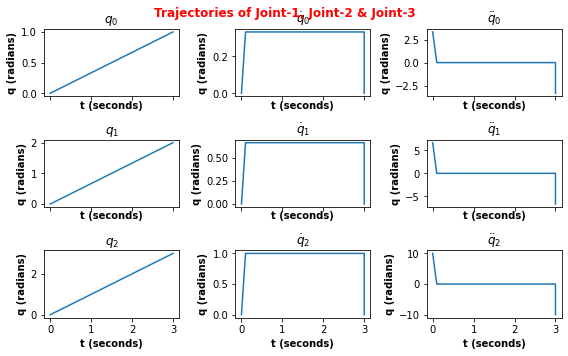

AttributeError: ignored

In [34]:
# Shubham Singh
# 21250025
# P2P Planning of Puma Robot with PI Controller

import numpy as np

t0 = int(input(" Enter t0: \n "))                                  #Enter Start time
tf = int(input("Enter tf:"))                                       #Enter End time
a1 = int(input('Enter the x coordinate of final position qf:'))    #Assuming Initial position as origin for trapezoidal trajectory
a2 = int(input('Enter the y coordinate of final position qf:'))
a3 = int(input('Enter the z coordinate of final position qf:'))

def main():
    dq_max = 1
    ddq_max = 20
    dx_max = 1
    ddx_max = 10
    n = 50
    cf = 10

    tg = TrajectoryGenerator(dq_max, ddq_max, dx_max, ddx_max, control_freq=cf)
    q_0 = [0.0, 0.0, 0.0]                                           # Trapezoidal joint trajectory
    q_f = [a1, a2, a3]                                               # q_f is the Coordinates of final point

    qs = tg.generate_p2p_trajectory(q_0, q_f, n=n, plot=True)        # q_0 coordinates are assumed to be at a refernce point
    robot = Puma()
    robot.move_joints(qs)
    return(qs)
if __name__ == '__main__':
    main()

def PI(Kp, Ki, qs_bar=0):                           #PI Controller for each joint variable
                                                    # Kp, Ki are the controller gains
    Kp = 0.1
    Ki = 1
    t = 2 
    e_prev = 0
    t_prev = -100
    I = 0
    SP = 2

    qs = qs_bar                                     # defining initial control
    
    while True:
        t, SP = yield qs                            #yield qs, waiting for t, setpoint 
        e = SP - qs                                 # e is the error 
        P = Kp*e
        I = I + Ki*e*(t - t_prev)
        qs_ = qs_bar + P + I 
        e_prev = e                                  # updating stored data for the next iteration
        t_prev = t
        return (qs)